# Store Sales Prediction

This is the EDA for the class Machine Learning at Chung Ang University. We have decided to enter the [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting) competition at Kaggle.

### Dataset Description (From Kaggle)
In this competition, we will predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

### Retrieve data from Kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"stefanovski","key":"7cc1fc34fbd4cde54785510fb03b40fe"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c 'store-sales-time-series-forecasting'

 23% 5.00M/21.4M [00:00<00:00, 38.1MB/s]
100% 21.4M/21.4M [00:00<00:00, 109MB/s] 


In [ ]:
! mkdir data

In [ ]:
! unzip store-sales-time-series-forecasting.zip -d data

Archive:  store-sales-time-series-forecasting.zip
  inflating: data/holidays_events.csv  
  inflating: data/oil.csv            
  inflating: data/sample_submission.csv  
  inflating: data/stores.csv         
  inflating: data/test.csv           
  inflating: data/train.csv          
  inflating: data/transactions.csv   


### Construct dataframes

In [ ]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.express as px   # For interactive graphs
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from matplotlib.lines import Line2D
from sklearn.impute import SimpleImputer

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
plt.rcParams['figure.figsize'] = (18, 9)

In [ ]:
train = pd.read_csv('data/train.csv', parse_dates=["date"])
stores = pd.read_csv('data/stores.csv')
oil = pd.read_csv('data/oil.csv', parse_dates=["date"])
holidays_events = pd.read_csv('data/holidays_events.csv', parse_dates=["date"])
transactions = pd.read_csv('data/transactions.csv', parse_dates=["date"])

In [ ]:
train['family'] = pd.Categorical(train['family'])
stores['city'] = pd.Categorical(stores['city'])
stores['state'] = pd.Categorical(stores['state'])
stores['type'] = pd.Categorical(stores['type'])
holidays_events['type'] = pd.Categorical(holidays_events['type'])
holidays_events['locale'] = pd.Categorical(holidays_events['locale'])
holidays_events['locale_name'] = pd.Categorical(holidays_events['locale_name'])

# EDA

## Dates

First and foremost, let's look at what time period is of relevance for this timeseries.

In [ ]:
train.date.min(), train.date.max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [ ]:
transactions.date.min(), transactions.date.max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [ ]:
oil.date.min(), oil.date.max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-31 00:00:00'))

We can tell that the train and transactions datasets only extend to 2017-08-15, whilst our oil dataset stretches to 2017-08-31. This is because the period 2017-08-16 to 27-08-31 is the test period which we make predicitons on.

Lets take a look at the continuity of dates

In [ ]:
continous_date = pd.date_range(start='2013-01-01 00:00:00', end='2017-08-31 00:00:00')
continous_date_df = pd.DataFrame(data={'date': continous_date})
continous_date_df['date'] = pd.to_datetime(continous_date_df['date'])

In [ ]:
all_dates = continous_date_df[continous_date_df['date'].notnull() == True].set_index('date')
oil_not_null = oil[oil['date'].notnull() == True].set_index('date')
transactions_grouped = transactions.groupby(by='date').sum()['transactions']
sales_grouped = train.groupby(by='date').sum()[['sales', 'onpromotion']]
all_dates = all_dates.join(oil_not_null, how='outer').join(transactions_grouped, how='outer').join(sales_grouped, how='outer')

In [ ]:
all_dates.isnull().sum()

dcoilwtico      529
transactions     22
sales            20
onpromotion      20
dtype: int64

There seems to be several dates that are missing information. Some of these are expected as the final 15 days of the daterange is the testset for the target. Nonetheless we will have to investigate further the discrepency between the 15 days and the number of null values. It is also clear that there are a lot of values missing for the price of oil. This may be because of days where the market is closed. As the next step in our EDA, we should compare the dates of missing values with public holidays. **We may want to infer these missing values during the data cleaning step, for example by utilizing interpolation.**

## Correlation

In [ ]:
all_dates.corr()['sales'].sort_values(ascending=False)

sales           1.00
transactions    0.68
onpromotion     0.57
dcoilwtico     -0.71
Name: sales, dtype: float64

Before making any plots we can already tell that our target is positivly correlated with both transactions and promotions. **It is also strongly negativly correlated with the price of oil.**

## Sales and Oil price

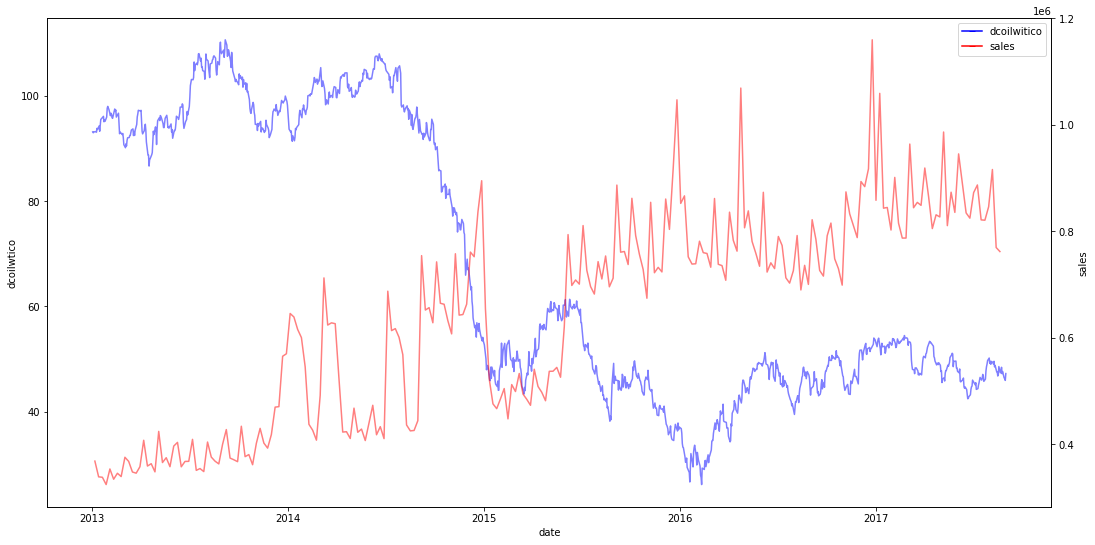

In [ ]:
ax1 = sb.lineplot(data=all_dates.dcoilwtico, color="b", alpha=0.5)
sb.lineplot(data=all_dates.sales.resample('W').mean(), color="r", ax=ax1.axes.twinx(), alpha=0.5)
ax1.legend(handles=[Line2D([], [], marker='_', color="b", label='dcoilwitico'), Line2D([], [], marker='_', color="r", label='sales')])

Even though there is a strong negative correlation between sales and the price of oil, it is difficult to deduce a clear pattern regarding their relation.

## Sales and Promotions

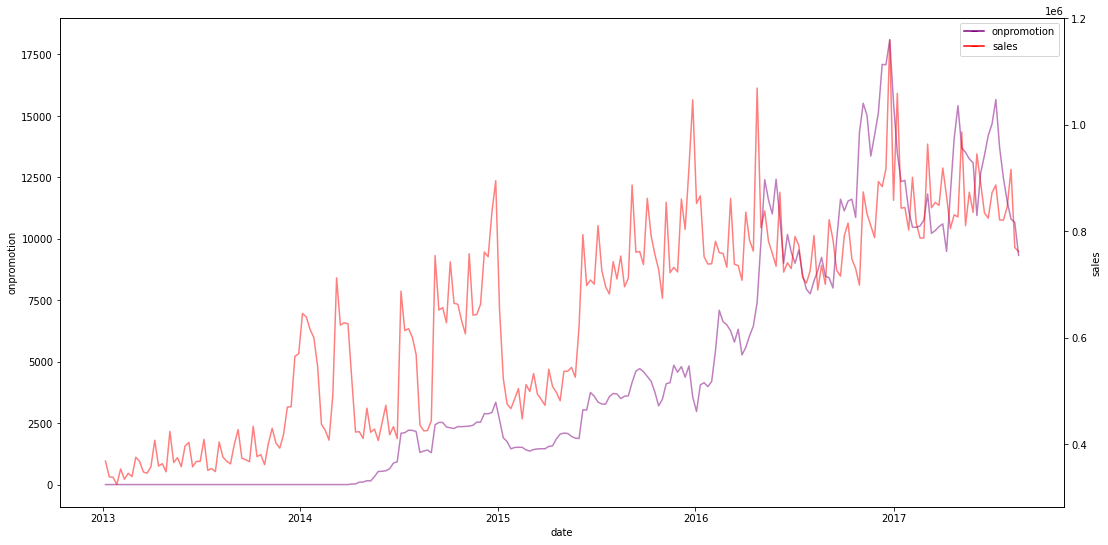

In [ ]:
ax1 = sb.lineplot(data=all_dates.onpromotion.resample('W').mean(), color="purple", alpha=0.5)
sb.lineplot(data=all_dates.sales.resample('W').mean(), color="r", ax=ax1.axes.twinx(), alpha=0.5)
ax1.legend(handles=[Line2D([], [], marker='_', color="purple", label='onpromotion'), Line2D([], [], marker='_', color="r", label='sales')])

There seems that no product was on promotion before Spring of 2014. Other than this, there seems to be a clear correlation.

## Different Product Families


In [ ]:
sales_aggregated = train.set_index(['date', 'store_nbr']).drop('id', axis=1).groupby(['date','family']).sum()

In [ ]:
family_sales = sales_aggregated.reset_index().set_index('date').pivot(columns='family', values='sales')

In [ ]:
most_important_products = family_sales.sum(axis=0).nlargest(9).index
most_important_sales = family_sales[most_important_products]
least_important_sales = family_sales.drop(most_important_products, axis=1).sum(axis=1).rename('OTHER')
most_important_sales = pd.concat([most_important_sales, least_important_sales], axis=1)

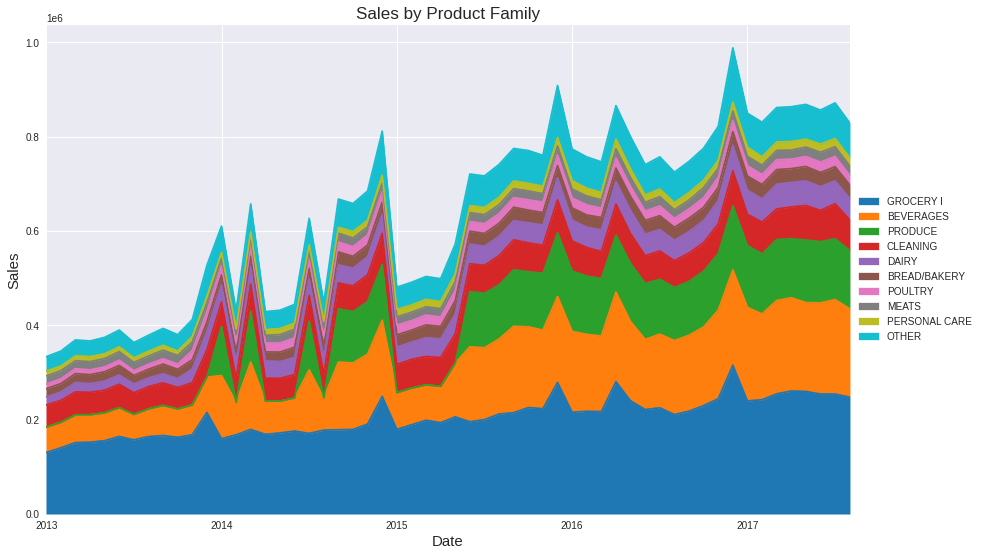

In [ ]:
plt.style.use('seaborn')
most_important_sales.resample('M').mean().plot.area(figsize=(18, 9), cmap='tab10')

plt.xlabel('Date', fontsize=15)
plt.ylabel('Sales', fontsize=15)
plt.title('Sales by Product Family',fontsize=17)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0], reverse=True))
ax.legend(handles, labels)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

From this chart we can tell that there seems to be a spike in sales, specifically 'GROCERIES' around december of each year. We can also see that there are multiple categories of product that vary substancially in sales throughout the years, such as 'PRODUCE', which often plummets. The rise of 'PRODUCE' sales is also accompanied by a rise in sales of 'BEVERAGES'. In addition to this, there seems to be a spike in sales in spring of 2016. This may be due to the sales increase caused by relief efforts after the earthquake April 16th, 2016. **Maybe we want to introduce a feature which takes this into account, i.e. "days_since_earquake", or "relief_effort"(bool)**

Let us investigate further the periodic properties of our target..

## Different Stores

In [ ]:
sales_by_store = train.set_index(['date', 'family']).drop('id', axis=1).groupby(['date','store_nbr']).sum()

In [ ]:
store_sales = sales_by_store.reset_index().set_index('date').pivot(columns='store_nbr', values='sales')

In [ ]:
most_important_stores = store_sales.sum(axis=0).nlargest(19).index
important_stores = store_sales[most_important_stores]
unimportant_stores = store_sales.drop(important_stores, axis=1).sum(axis=1).rename('OTHER')
important_stores = pd.concat([important_stores, unimportant_stores], axis=1)

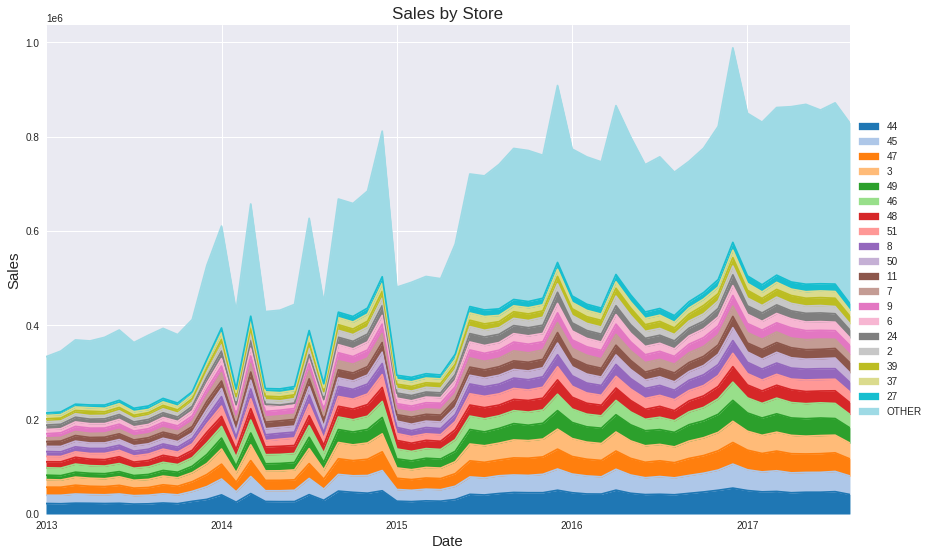

In [ ]:
plt.style.use('seaborn')
important_stores.resample('M').mean().plot.area(figsize=(18, 9), cmap='tab20')

plt.xlabel('Date', fontsize=15)
plt.ylabel('Sales', fontsize=15)
plt.title('Sales by Store',fontsize=17)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0], reverse=True))
ax.legend(handles, labels)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

This tells us that the sale of good is quite equally distributed among different stores.

## Sales and Locations

In [ ]:
sales_and_locations = sales_by_store.join(stores, on='store_nbr')

## Sales and Transactions

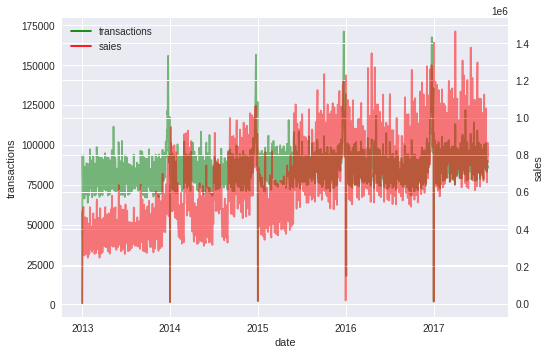

In [ ]:
ax1 = sb.lineplot(data=all_dates.transactions, color="g", alpha=0.5)
sb.lineplot(data=all_dates.sales, color="r", ax=ax1.axes.twinx(), alpha=0.5)
ax1.legend(handles=[Line2D([], [], marker='_', color="g", label='transactions'), Line2D([], [], marker='_', color="r", label='sales')])

The spike in sales around newyears is also reflected in the number of transactions during this time. There also seems to be smaller spikes in sales and transactions in more frequent periods. Let us investigate the fluctuations further..

## Peroidic Properties

### Period of One Week

In [ ]:
periodic = all_dates.copy()
periodic['year'] = periodic.index.year
periodic["day_of_month"] = periodic.index.day+1
periodic["day_of_week"] = periodic.index.dayofweek+1
periodic_week = periodic.groupby(["year", "day_of_week"]).transactions.mean().reset_index()
px.line(periodic_week, x='day_of_week', y='transactions', color='year',title = "Monthly Average Transactions" )

There is an increase in transactions on Fridays and Saturdays

### Period of One Month

In [ ]:
periodic_month = periodic.groupby(["year", "day_of_month"]).transactions.mean().reset_index()
px.line(periodic_month, x='day_of_month', y='transactions', color='year',title = "Monthly Average Transactions" )

### Period of One Year

There seems to be a dip of transactions towards the last week of the month, which then undergoes a sudden increase towards the end. This may be explained as the result of salaries being paid at the last day of the week in the public sector. Salaries are also paid on the 15th, but this is oddly not appearant in the number of transactions.

In [ ]:
periodic_year = periodic.groupby(["year", "date"]).transactions.mean().reset_index().set_index('date')
px.line(periodic_year, y='transactions', color='year',title = "Monthly Average Transactions" )

We can now determine that the yearly spike in transactions occurs on December 24th each year, and that the sharp decrease occurs on January 1st. We might want to use the holidays dataset to detect less obvious fluctuations that are caused by lesser known holidays.

Through the preceding graphs it is appearant that the number of transactions fluctuate in periods of years, months and weeks. **We can capitalize on this by introducing lag columns which will aid our model in it's predictions.** But first we should examine the autocorrelation values to determine which lag is the most beneficial.

## Variation

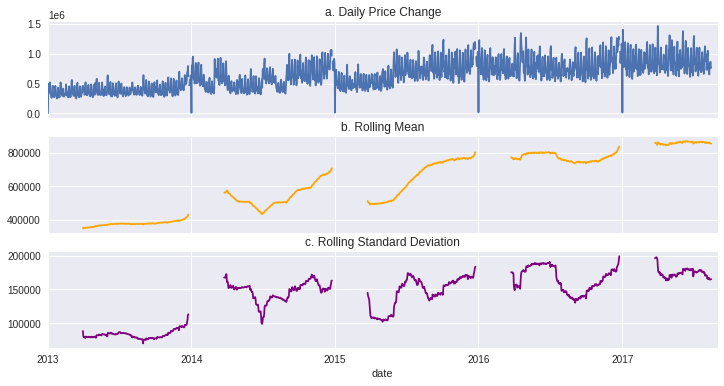

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1)
all_dates['sales'].plot(ax=axes[0], figsize=(12,6), rot=90, title='a. Daily Price Change', sharex=True)
all_dates['sales'].rolling(90).mean().plot(ax=axes[1], figsize=(12,6), rot=90, title='b. Rolling Mean', color='orange')
all_dates['sales'].rolling(90).std().plot(ax=axes[2], figsize=(12,6), rot=0, title='c. Rolling Standard Deviation', color='purple')
plt.show()

## Autocorrelation

In [ ]:
interesting_lags = (1, 2, 3, 4, 5, 6, 7, 14, 15, 21, 27, 28, 29, 30, 31, 365, 730)

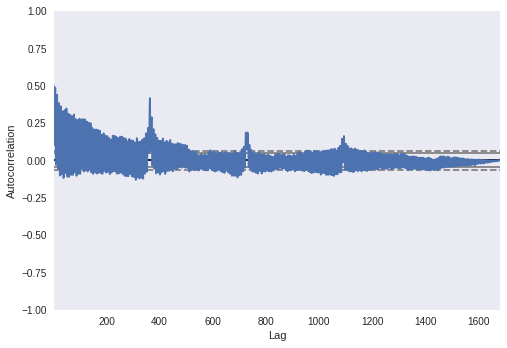

In [ ]:
pd.plotting.autocorrelation_plot(all_dates['transactions'].dropna())

In [ ]:
[print(f'Lag: {lag}\t\t Autocorr: {all_dates["transactions"].autocorr(lag=lag):.2f}') for lag in interesting_lags]
print()

Lag: 1		 Autocorr: 0.52
Lag: 2		 Autocorr: 0.18
Lag: 3		 Autocorr: 0.12
Lag: 4		 Autocorr: 0.08
Lag: 5		 Autocorr: 0.11
Lag: 6		 Autocorr: 0.36
Lag: 7		 Autocorr: 0.63
Lag: 14		 Autocorr: 0.44
Lag: 15		 Autocorr: 0.25
Lag: 21		 Autocorr: 0.38
Lag: 27		 Autocorr: 0.18
Lag: 28		 Autocorr: 0.37
Lag: 29		 Autocorr: 0.19
Lag: 30		 Autocorr: -0.05
Lag: 31		 Autocorr: -0.09
Lag: 365		 Autocorr: 0.64
Lag: 730		 Autocorr: 0.23



It seems that lags of 1, 7, 14, 21, 28 and 365 stand out as useful.

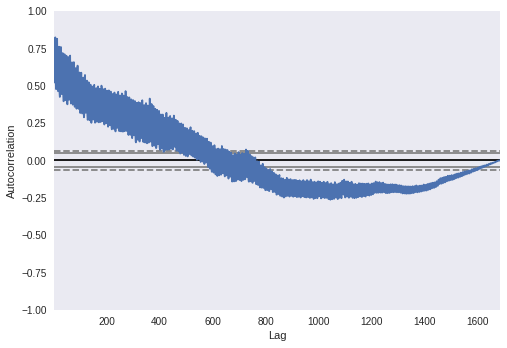

In [ ]:
pd.plotting.autocorrelation_plot(all_dates['sales'].dropna())

In [ ]:
[print(f'Lag: {lag}\t\t Autocorr: {all_dates["sales"].autocorr(lag=lag):.2f}') for lag in interesting_lags]
print()

Lag: 1		 Autocorr: 0.77
Lag: 2		 Autocorr: 0.56
Lag: 3		 Autocorr: 0.53
Lag: 4		 Autocorr: 0.52
Lag: 5		 Autocorr: 0.54
Lag: 6		 Autocorr: 0.70
Lag: 7		 Autocorr: 0.85
Lag: 14		 Autocorr: 0.82
Lag: 15		 Autocorr: 0.68
Lag: 21		 Autocorr: 0.78
Lag: 27		 Autocorr: 0.64
Lag: 28		 Autocorr: 0.78
Lag: 29		 Autocorr: 0.66
Lag: 30		 Autocorr: 0.49
Lag: 31		 Autocorr: 0.46
Lag: 365		 Autocorr: 0.58
Lag: 730		 Autocorr: 0.23



For sales the autocorrelation is strong for recent dates, as well as for the dates of interest noted earlier. That is, 365 and muliples of 7.

**We should examine the correlation between sales, on_promotion and transactions with their given lags.**

# Data Cleaning

## Holidays and Events

In [ ]:
holiday = holidays_events.loc[holidays_events["type"] == "Holiday"]
additional = holidays_events.loc[holidays_events["type"] == "Additional"]
transfer = holidays_events.loc[holidays_events["type"] == "Transfer"]
bridge = holidays_events.loc[holidays_events["type"] == "Bridge"]
work_day = holidays_events.loc[holidays_events["type"] == "Work Day"]

In [ ]:
holiday[holiday['transferred'] == True].shape == transfer.shape

True

It seems that  all the transferred holidays / events are in fact holidays.

In [ ]:
# This code is taken from https://www.kaggle.com/code/ekrembayar/store-sales-ts-forecasting-a-comprehensive-guide#6.-Holidays-and-Events
# It corrects the transferred holidays and places them on the actual day it was celebrated
tr1 = holidays_events[(holidays_events.type == "Holiday") & (holidays_events.transferred == True)].drop("transferred", axis = 1).reset_index(drop = True)
tr2 = holidays_events[(holidays_events.type == "Transfer")].drop("transferred", axis = 1).reset_index(drop = True)
tr = pd.concat([tr1,tr2], axis = 1)
tr = tr.iloc[:, [5,1,2,3,4]]

holiday = holiday[(holiday.transferred == False) & (holiday.type != "Transfer")].drop("transferred", axis = 1)
holiday = holiday.append(tr).reset_index(drop = True)
holiday

,date,type,locale,locale_name,description
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba
...,...,...,...,...,...
216,2017-04-13,Holiday,Local,Cuenca,Fundacion de Cuenca
217,2017-05-26,Holiday,National,Ecuador,Batalla de Pichincha
218,2017-08-11,Holiday,National,Ecuador,Primer Grito de Independencia
219,2017-09-29,Holiday,Local,Ibarra,Fundacion de Ibarra


## Transactions and onpromotion

In [ ]:
cleaned = train.merge(transactions, on=['store_nbr', 'date']).sort_values(["store_nbr", "family", "date"])
cleaned.isnull().sum().sum()

0

# Feature Engineering

## Time Columns

Since there seems to be consistent jumps in sales toward the end of each week, we can introduce a feature "is_weekend"

In [ ]:
cleaned["is_weekend"] = (cleaned.date.dt.weekday // 4).astype("int8")

Now let's analyse what kind of lag correlates most with our target. Here we have to beware that we cannot have a lag of less than 15 because that would not be useable for our test-set.

In [ ]:
cleaned['sales_lag21'] =  cleaned.groupby(["store_nbr", "family"]).sales.shift(21)
cleaned['sales_lag28'] =  cleaned.groupby(["store_nbr", "family"]).sales.shift(28)
cleaned["sales_lag16_SMA60"] = cleaned.groupby(["store_nbr", "family"]).rolling(60).sales.mean().shift(16).values
cleaned["sales_lag16_SMA365"] = cleaned.groupby(["store_nbr", "family"]).rolling(365).sales.mean().shift(16).values

In [ ]:
cleaned.corr()['sales'].sort_values(ascending=False)

sales                1.00
sales_lag21          0.92
sales_lag28          0.91
sales_lag16_SMA60    0.91
sales_lag16_SMA365   0.90
onpromotion          0.43
transactions         0.21
id                   0.07
store_nbr            0.06
is_weekend           0.04
Name: sales, dtype: float64